In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [3]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst_new = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    # '死亡受傷人數',
    # '經度', '緯度',
    # '死亡', '受傷'
]
select_lst = [
    '路面狀況-路面狀態名稱',
    # '肇因研判大類別名稱-主要', # 降低預測值
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    # '當事者區分-類別-大類別名稱-車種', # 降低預測值
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    # '路面狀況-路面鋪裝名稱', '道路障礙-視距名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他',
    # '道路障礙-障礙物名稱', '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱', '車輛撞擊部位子類別名稱-其他',
    '死亡受傷人數',
    '經度', '緯度',
]
# select_lst = [
#     '光線名稱',
#     '道路類別-第1當事者-名稱',
#     '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
#     '道路型態大類別名稱', '事故位置大類別名稱', 
#     # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
#     '死亡受傷人數',
#     '經度', '緯度',
# ]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11840) # 120420

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1)

print(full_dist.shape)
full_dist.head()

(121012, 32)


,路面狀況-路面狀態名稱,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,...,行動電話或電腦或其他相類功能裝置名稱,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,號誌-號誌動作名稱,經度,緯度,死亡,受傷
0,-0.331183,0.739901,-1.09744,-0.372169,0.146102,2.120706,-0.146069,1.210906,0.485564,-0.713755,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,0.837867,-0.634220,-1.868211,13.660843,-2.803204
1,-0.331183,0.739901,0.67326,1.175119,1.465217,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,-1.192531,1.111877,0.974928,13.660843,-0.620846
2,-0.331183,0.739901,0.67326,-0.372169,-1.173013,2.911514,-0.146069,1.210906,1.164664,-0.713755,...,-2.147278,-5.676019,-0.314290,0.508523,-0.135001,0.837867,-2.459704,-0.633180,13.660843,-2.803204
3,-0.331183,0.739901,-0.21209,-0.372169,-1.173013,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,-1.192531,0.936797,1.016777,13.660843,-0.620846
4,-0.331183,0.739901,-1.09744,-0.372169,1.465217,2.120706,-0.146069,1.210906,1.164664,-0.713755,...,-2.147278,0.147005,2.579597,0.508523,-0.135001,0.837867,1.832866,0.186897,13.660843,-2.803204


In [4]:
rbind_data.shape[0] == full_dist.shape[0]

True

In [6]:
def find_ratio(input_data, components) :
    best_comp = {}
    for comp in range(1,components+1):   
        pca = PCA(comp).fit(input_data)
        
        best_comp[comp] = pca.explained_variance_ratio_.sum()
        
    max_comp = max(best_comp, key=best_comp.get)  # 使用 key=best_comp.get 找到最大值的鍵
    print("最佳成分數：", max_comp)
    print("解釋方差比率累計值：", best_comp[max_comp])

lens1 = find_ratio(full_dist, 9)

最佳成分數： 9
解釋方差比率累計值： 0.5190573767926034


In [7]:
lens1 = PCA(10) # 10 最好
lens_result = lens1.fit_transform(X1[select_lst_new].to_numpy())

db = DBSCAN(eps=2.7, min_samples=10).fit(lens_result) # 2.7最好、最低2.2
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

n_clusters_

3

In [8]:
noise_mask = labels == -1
noise_rows = rbind_data[noise_mask]

noise_rows.shape

(63, 32)

In [237]:
noise_rows.to_csv('CalculatedData/離群比較/原始27.csv', index=False)

In [226]:
# logistic_lst = [
#     '光線名稱',
#     '道路類別-第1當事者-名稱',
#     '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
#     '道路型態大類別名稱', '事故位置大類別名稱', 
#     # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
# ]

# denoise_data = rbind_data[~noise_mask]
# origin_X, origin_y = get_clusterN_logit(denoise_data, logistic_lst)

# start_time = time.time()

# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# print(score_origin)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

In [49]:
# data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[data_origin.columns]

# denoise_data_from_mapper = rbind_data.loc[rbind_data[~rbind_data.apply(tuple, axis=1).isin(data_mapper.apply(tuple, axis=1))].index]

# origin_X, origin_y = get_clusterN_logit(denoise_data_from_mapper, logistic_lst)

# import time
# start_time = time.time()

# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# print(score_origin)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

## 比較不同的離群
### 主要依照拓墣的區分方式，道路分析拓墣為15個欄位，而data_mapper是因為分類所以增加欄位

In [2]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始27.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[lst_logit]

print(data_origin.shape)
print(data_mapper.shape)

(63, 28)
(131, 28)


In [3]:
overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(non_overlapping_rows_origin.shape)
print(non_overlapping_rows_mapper.shape)
print('重複：', overlapping_rows.shape[0])

print(len(overlapping_index_origin) == len(overlapping_index_mapper))
print(overlapping_rows_origin.shape[0] == overlapping_rows_mapper.shape[0])

(10, 28)
(78, 28)
重複： 53
True
True


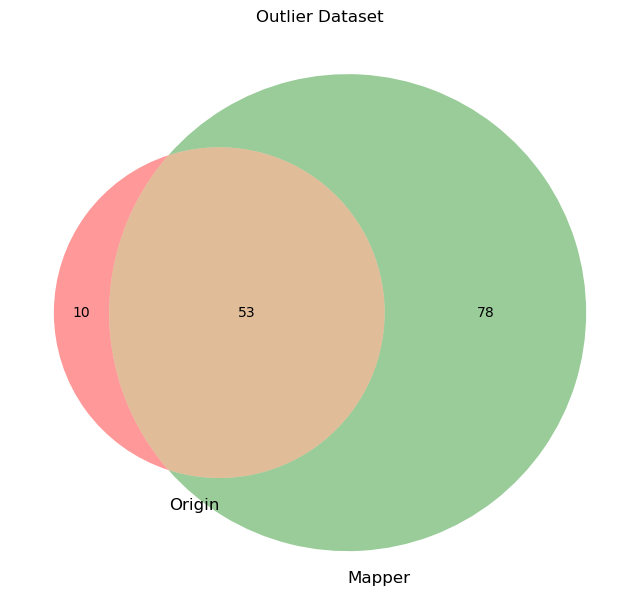

In [4]:
from matplotlib_venn import venn2 # 文氏圖

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

origin_set = set(range(total_origin))
mapper_set = set(range(total_mapper))

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('Outlier Dataset')
plt.show()

## 6/28 重疊部分和只有Mapper的分類

In [5]:
overlapping_rows = pd.merge(data_origin, data_mapper)
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows['type'] = 'overlap'
non_overlapping_rows_mapper['type'] = 'mapper'

data_combined = pd.concat([non_overlapping_rows_mapper, overlapping_rows], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)

full_dist.drop(['type'], axis=1, inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(full_dist, typedt, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

p_values = result.pvalues
significant_factors = p_values[p_values < 0.05]
significant_factors.sort_values()

Optimization terminated successfully.
         Current function value: 0.162816
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  104
Model:                          Logit   Df Residuals:                       76
Method:                           MLE   Df Model:                           27
Date:                Sat, 29 Jun 2024   Pseudo R-squ.:                  0.7586
Time:                        19:14:14   Log-Likelihood:                -16.933
converged:                       True   LL-Null:                       -70.152
Covariance Type:            nonrobust   LLR p-value:                 2.203e-11
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
路面狀況-路面狀態名稱                -0.3365      0.808     -0.416      0.677      -1.921  

車道劃分設施-分道設施-快慢車道間名稱    0.019432
事故類型及型態大類別名稱           0.023359
dtype: float64

In [29]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Overlap'
    df2_counts['Source'] = 'Mapper'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=30)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    plt.show()

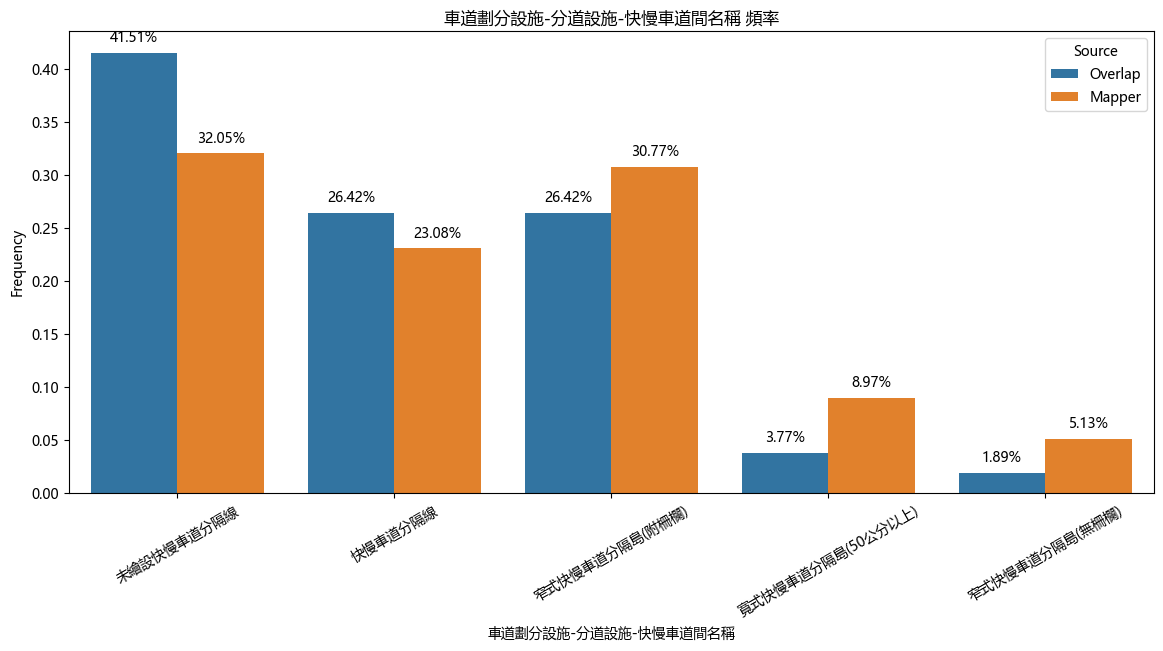

In [30]:
plot_bar_comparison(overlapping_rows, non_overlapping_rows_mapper, '車道劃分設施-分道設施-快慢車道間名稱')

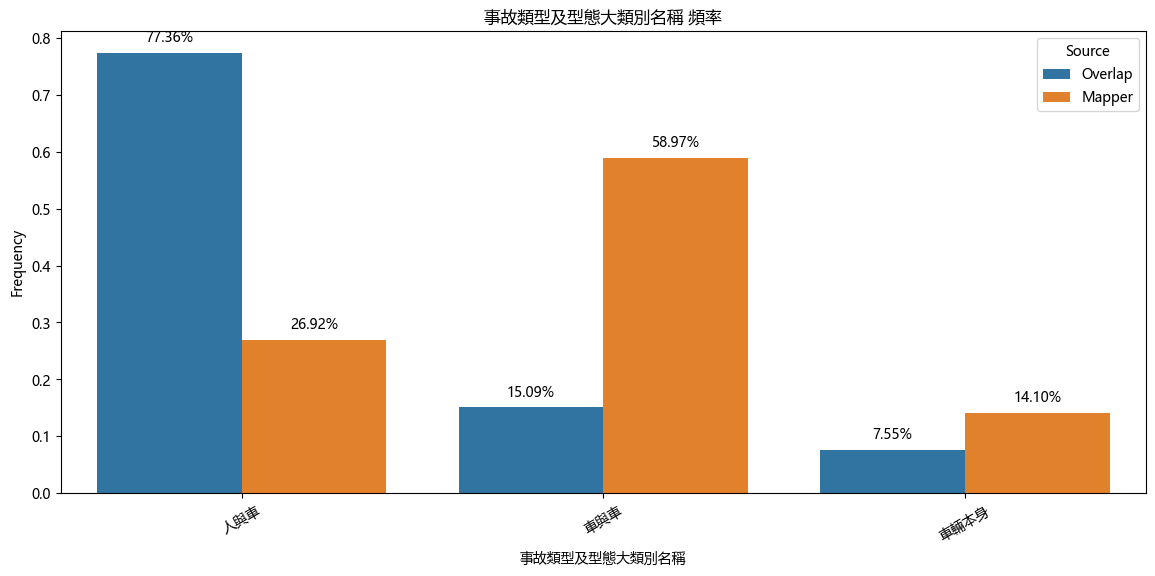

In [31]:
plot_bar_comparison(overlapping_rows, non_overlapping_rows_mapper, '事故類型及型態大類別名稱')

## 6/28 獨立出A1 A2的Venn圖

In [5]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡', '受傷'
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始27.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[lst_logit]

### V1 圖

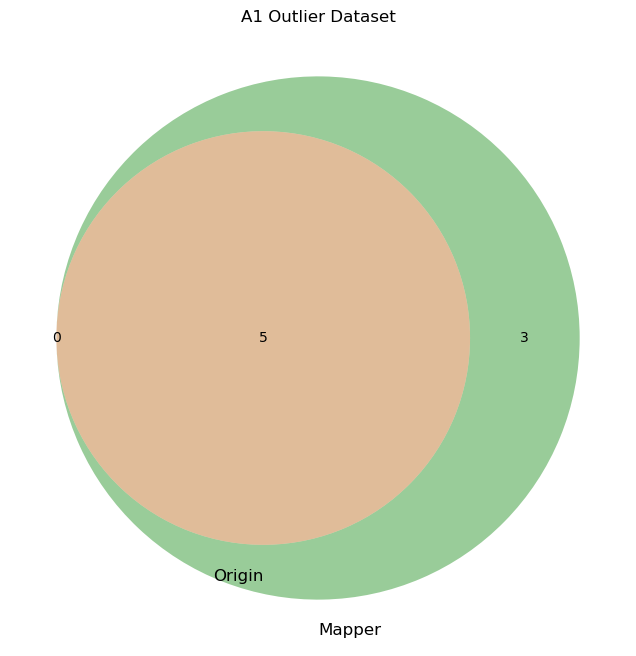

In [6]:
data_origin = data_origin[data_origin['死亡'] != 0]
data_mapper = data_mapper[data_mapper['死亡'] != 0]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('A1 Outlier Dataset')
plt.show()

In [12]:
non_overlapping_rows_mapper[['車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱',
       '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱',
       '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別']]

,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,事故位置子類別名稱,事故類型及型態子類別名稱,當事者行動狀態子類別名稱,車輛撞擊部位子類別名稱-最初,肇因研判子類別名稱-個別
0,中央分向島,車道線(無標記),窄式快慢車道分隔島(無柵欄),有,車與車,交叉口附近,追撞,向前直行中,前車頭,未保持行車安全距離
1,中央分向島,車道線(附標記),窄式快慢車道分隔島(附柵欄),有,車輛本身,慢車道,路上翻車、摔倒,向前直行中,右側車身,恍神、緊張、心不在焉分心駕駛
11,無,未繪設車道線,未繪設快慢車道分隔線,無,車輛本身,交叉路口內,撞電桿,向前直行中,前車頭,未依規定減速


In [13]:
overlapping_rows_mapper[['車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱',
       '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱',
       '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別']]

,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,事故位置子類別名稱,事故類型及型態子類別名稱,當事者行動狀態子類別名稱,車輛撞擊部位子類別名稱-最初,肇因研判子類別名稱-個別
3,中央分向島,車道線(附標記),寬式快慢車道分隔島(50公分以上),有,人與車,慢車道,其他,其他,非汽、機及自行車,其他引起事故之疏失或行為
5,中央分向島,車道線(附標記),未繪設快慢車道分隔線,有,人與車,路肩、路緣,在路上作業中,其他,非汽、機及自行車,在道路上工作之人員未設適當標識
6,中央分向島,車道線(附標記),未繪設快慢車道分隔線,有,人與車,路肩、路緣,其他,向前直行中,右側車身,恍神、緊張、心不在焉分心駕駛
7,中央分向島,車道線(附標記),未繪設快慢車道分隔線,有,人與車,快車道,穿越道路中,等待(引擎未熄火),無撞擊,尚未發現肇事因素
9,中央分向島,車道線(無標記),快慢車道分隔線,有,人與車,交叉路口內,穿越道路中,向前直行中,右前車頭(身),未依規定減速


In [8]:
non_overlapping_rows_mapper

,路面狀況-路面狀態名稱,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,...,當事者區分-類別-子類別名稱-車種,保護裝備名稱,行動電話或電腦或其他相類功能裝置名稱,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,號誌-號誌動作名稱,死亡,受傷
0,乾燥,男,3.0,汽車,有照明且開啟,其他,1,交岔路,交叉路口,行車管制號誌,...,自用,繫安全帶(使用幼童安全椅),未使用,車的狀態,NaN,駕駛者,否,正常,1,1
1,乾燥,女,4.0,機車與自行車,有照明未開啟或故障,省道,0,單路部分,路段,無號誌,...,普通重型,戴非半罩式安全帽,未使用,車的狀態,NaN,駕駛者,否,無號誌,1,0
11,乾燥,男,3.0,機車與自行車,有照明未開啟或故障,省道,1,交岔路,交叉路口,閃光號誌,...,普通重型,戴半罩式安全帽,未使用,車的狀態,NaN,駕駛者,否,正常,1,0


In [9]:
overlapping_rows_mapper

,路面狀況-路面狀態名稱,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,...,當事者區分-類別-子類別名稱-車種,保護裝備名稱,行動電話或電腦或其他相類功能裝置名稱,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,號誌-號誌動作名稱,死亡,受傷
3,乾燥,男,2.0,其他,有照明且開啟,省道,1,單路部分,路段,無號誌,...,行人,其他(無需使用保護裝備之人),非駕駛人,人的狀態,NaN,非駕駛者,否,無號誌,1,0
5,乾燥,男,3.0,其他,無照明,國道,1,單路部分,路段,無號誌,...,其他人,其他(無需使用保護裝備之人),非駕駛人,人的狀態,NaN,非駕駛者,否,無號誌,1,0
6,乾燥,男,3.0,汽車,無照明,國道,1,單路部分,路段,無號誌,...,營業用,繫安全帶(使用幼童安全椅),未使用,車的狀態,NaN,駕駛者,否,無號誌,1,0
7,乾燥,男,2.0,其他,無照明,國道,1,單路部分,路段,無號誌,...,計程車,繫安全帶(使用幼童安全椅),未使用,車的狀態,NaN,無(車輛駕駛者因素),否,無號誌,1,0
9,乾燥,男,3.0,汽車,有照明且開啟,省道,1,交岔路,交叉路口,無號誌,...,自用,繫安全帶(使用幼童安全椅),未使用,車的狀態,NaN,駕駛者,否,無號誌,1,0


### V2 圖

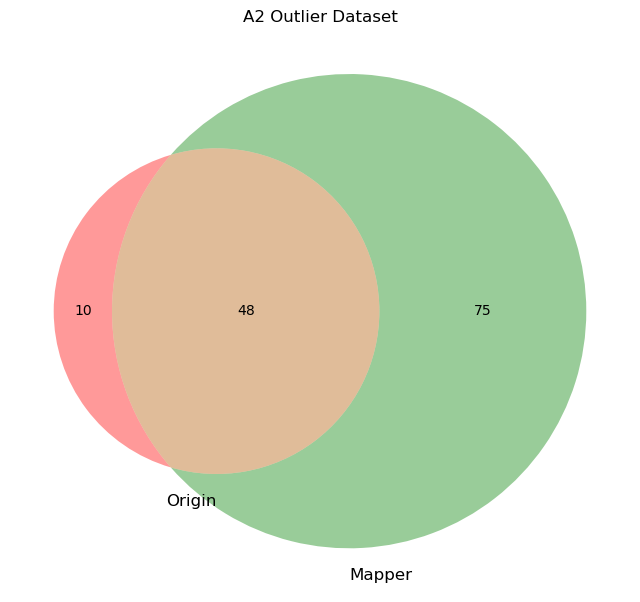

In [41]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始27.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[lst_logit]

data_origin = data_origin[data_origin['死亡'] == 0]
data_mapper = data_mapper[data_mapper['死亡'] == 0]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('A2 Outlier Dataset')
plt.show()

### Origin 分群

In [583]:
# origin_X, origin_y = get_clusterN_logit(data_origin, logistic_lst)
# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# cm_origin

### Mapper 分群

In [584]:
# mapper_X, mapper_y = get_clusterN_logit(data_mapper, logistic_lst)
# matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)
# cm_mapper

試圖對三個區塊做PCA，找出overlap群體較為接近哪一個群體

# 分析

In [592]:
col = ['事故類型及型態大類別名稱', '速限-第1當事者', '車道劃分設施-分道設施-快慢車道間名稱']
for i in col:
    print(non_overlapping_rows_origin[i].value_counts(normalize=True))
    print(non_overlapping_rows_mapper[i].value_counts(normalize=True))
    print('-------------------------------------------')

車與車     0.5
車輛本身    0.4
人與車     0.1
Name: 事故類型及型態大類別名稱, dtype: float64
車與車     0.589744
人與車     0.269231
車輛本身    0.141026
Name: 事故類型及型態大類別名稱, dtype: float64
-------------------------------------------
1    0.7
0    0.3
Name: 速限-第1當事者, dtype: float64
0    0.602564
1    0.397436
Name: 速限-第1當事者, dtype: float64
-------------------------------------------
寬式快慢車道分隔島(50公分以上)    0.4
窄式快慢車道分隔島(附柵欄)       0.4
未繪設快慢車道分隔線           0.2
Name: 車道劃分設施-分道設施-快慢車道間名稱, dtype: float64
未繪設快慢車道分隔線           0.320513
窄式快慢車道分隔島(附柵欄)       0.307692
快慢車道分隔線              0.230769
寬式快慢車道分隔島(50公分以上)    0.089744
窄式快慢車道分隔島(無柵欄)       0.051282
Name: 車道劃分設施-分道設施-快慢車道間名稱, dtype: float64
-------------------------------------------


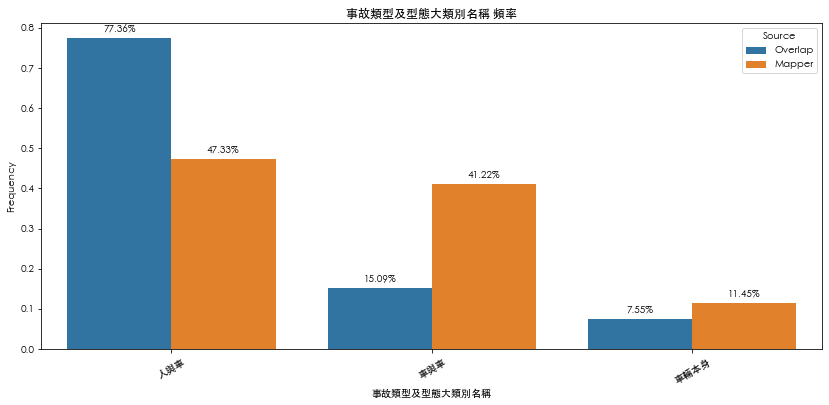

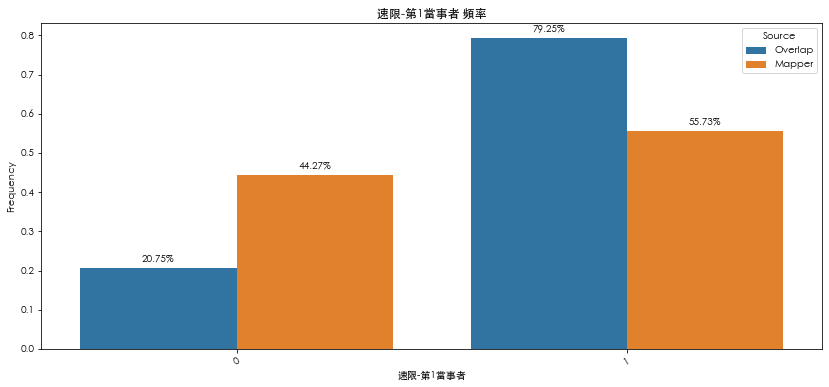

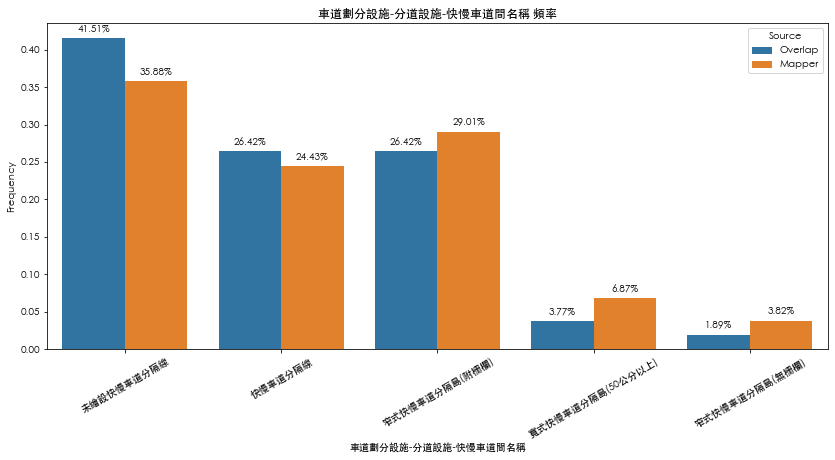

In [ ]:
plt.rcParams['font.sans-serif'] = ['STHeiti']
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Overlap'
    df2_counts['Source'] = 'Mapper'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=30)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    plt.show()

for feature in col:
    plot_bar_comparison(overlapping_rows, non_overlapping_rows_mapper, feature)

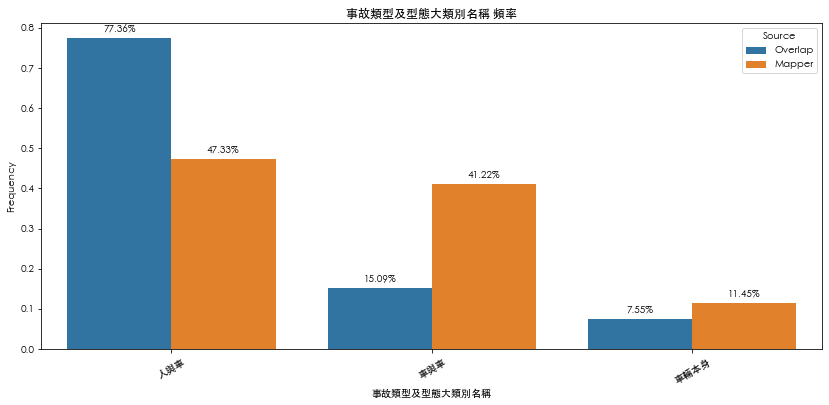

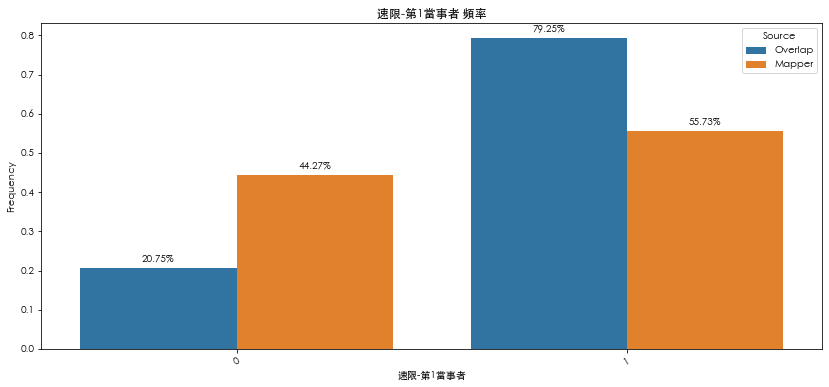

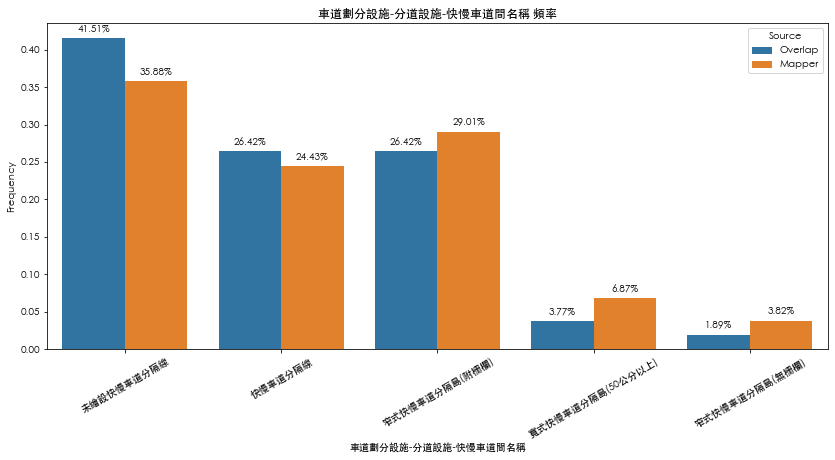

In [596]:
for feature in col:
    plot_bar_comparison(overlapping_rows, data_mapper, feature)

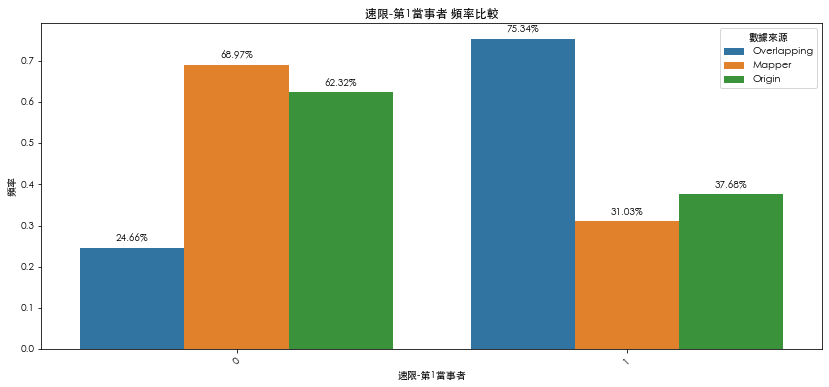

In [560]:
plot_bar_comparison(non_overlapping_rows_origin, non_overlapping_rows_mapper, overlapping_rows, '速限-第1當事者')

In [570]:
def plot_bar_comparison(df1, df2, df3, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    df3_counts = df3[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Origin'
    df2_counts['Source'] = 'Mapper'
    df3_counts['Source'] = 'Overlapping'

    combined_counts = pd.concat([df3_counts, df2_counts, df1_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']
    
    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率比較')
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel('頻率')
    plt.legend(title='數據來源')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    
    plt.show()

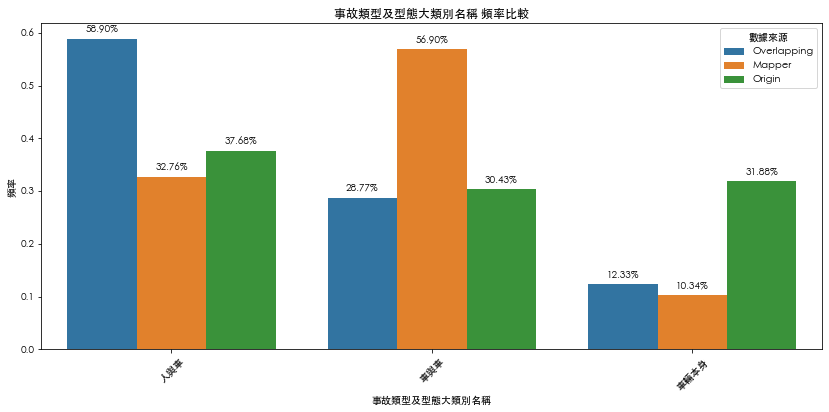

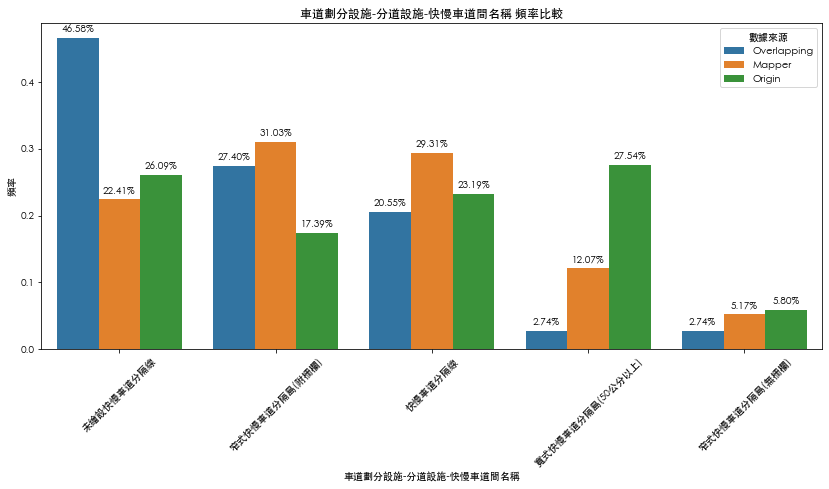

In [561]:
for feature in col:
    plot_bar_comparison(non_overlapping_rows_origin, non_overlapping_rows_mapper, overlapping_rows, feature)

## 離群最終，資料點抽樣以及離群點增加

In [38]:
select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    # '死亡受傷人數',
    # '經度', '緯度',
    # '死亡', '受傷'
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始27.csv')[select_lst]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[select_lst]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列做篩選
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(data_origin.shape)
print(data_mapper.shape)

overlapping_rows_mapper.shape[0] == overlapping_rows_origin.shape[0]

(63, 11)
(131, 11)


True

In [39]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)#.sample(sample).reset_index(drop=True)
    # sample_data = sample_data[sample_data['發生月份'] == 1]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
    # '死亡', '受傷'
]
# select_lst = [
#     '路面狀況-路面狀態名稱',
#     # '肇因研判大類別名稱-主要', # 降低預測值
#     '當事者屬-性-別名稱', '當事者事故發生時年齡', 
#     '車輛撞擊部位大類別名稱-最初',
#     '光線名稱',
#     '道路類別-第1當事者-名稱',
#     '速限-第1當事者',
#     '道路型態大類別名稱',
#     '事故位置大類別名稱', 
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
#     '事故位置子類別名稱', '事故類型及型態子類別名稱', 
#     '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
#     # '當事者區分-類別-大類別名稱-車種', # 降低預測值
#     '當事者區分-類別-子類別名稱-車種',
#     '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
#     '當事者行動狀態大類別名稱',
#     '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
#     '號誌-號誌動作名稱',
#     # '路面狀況-路面鋪裝名稱', '道路障礙-視距名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他',
#     # '道路障礙-障礙物名稱', '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱', '車輛撞擊部位子類別名稱-其他',
#     '死亡受傷人數',
#     '經度', '緯度',
# ]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 30000) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

rbind_data.shape

(121012, 15)

### 去掉離群比較

In [40]:
logistic_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]
def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['死亡'] != 0 else 2, axis=1)
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y

### 去掉原始資料獲取的離群

In [49]:
pd.merge(rbind_data, data_origin).shape

(77, 15)

In [27]:
overlapping_rows_origin = pd.merge(rbind_data, data_origin)
rbind_data_filtered = rbind_data[~rbind_data.apply(tuple, axis=1).isin(overlapping_rows_origin.apply(tuple, axis=1))]

origin_X, origin_y = get_clusterN_logit(rbind_data_filtered, logistic_lst)

print(origin_X.shape)

(121012, 11)


In [44]:
matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
score_origin

0.655367231638418

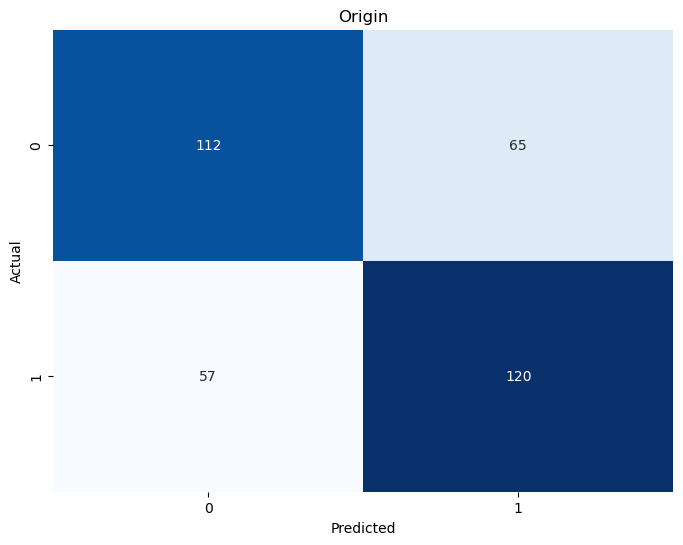

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_origin, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Origin')

plt.show()

### 去掉Mapper獲取的離群

In [48]:
pd.merge(rbind_data, data_mapper).shape

(225, 15)

In [50]:
overlapping_rows_mapper = pd.merge(rbind_data, data_mapper)
rbind_data_filtered = rbind_data[~rbind_data.apply(tuple, axis=1).isin(overlapping_rows_mapper.apply(tuple, axis=1))]

mapper_X, mapper_y = get_clusterN_logit(rbind_data_filtered, logistic_lst)

print(origin_X.shape)

(121012, 11)


In [51]:
matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)
score_mapper

0.6628571428571428

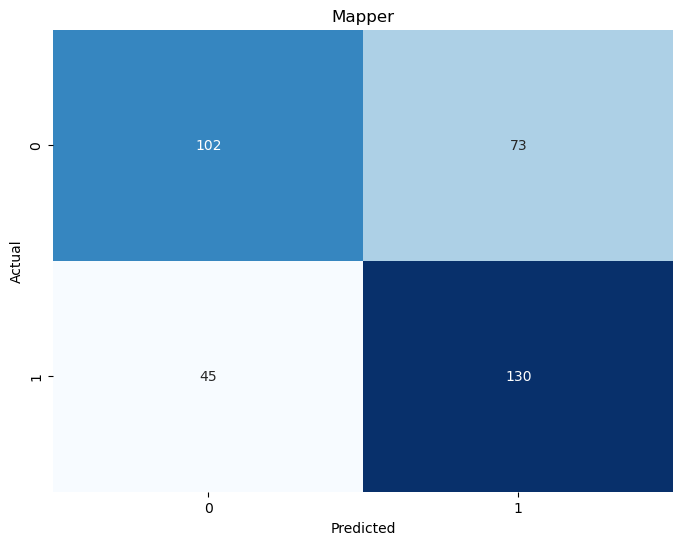

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mapper, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mapper')

plt.show()

### 原始資料預測

In [56]:
X, y = get_clusterN_logit(rbind_data, logistic_lst)
matri, score, cmr = logistic_cm_gridsearch(X, y)

score

0.655367231638418

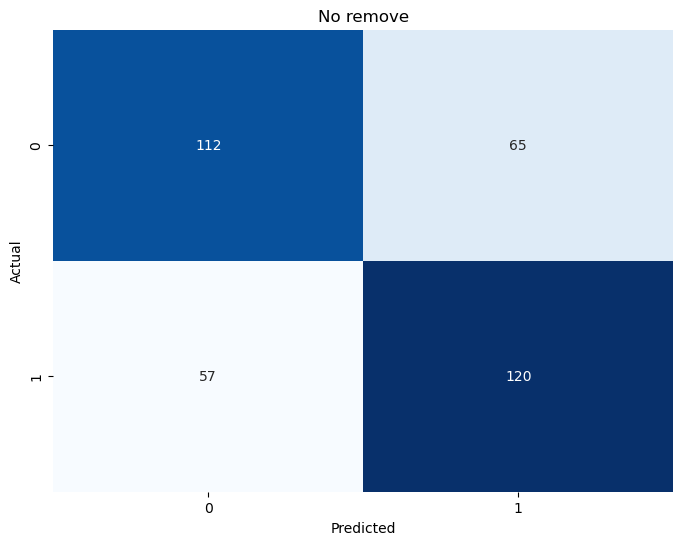

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(cmr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('No remove')

plt.show()

In [159]:
print(matrix_origin)
print(matrix_mapper)
print(matri)

     Label  Precision    Recall  F1 Score
0  Class_0   0.662722  0.636364  0.649275
1  Class_1   0.650273  0.676136  0.662953
     Label  Precision    Recall  F1 Score
0  Class_0   0.693878  0.582857  0.633540
1  Class_1   0.640394  0.742857  0.687831
     Label  Precision    Recall  F1 Score
0  Class_0   0.662722  0.632768  0.647399
1  Class_1   0.648649  0.677966  0.662983
